In [26]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.patches as patches

In [78]:
# arguments
cam_H, cam_W = 580, 890
wvls = np.arange(420, 670, 10)
patch_size = 25
n_illum = 128
n_patches = 4
n_channel = 3

### Get R,G,B,W patches information

Text(0.5, 0, 'wavelength [nm]')

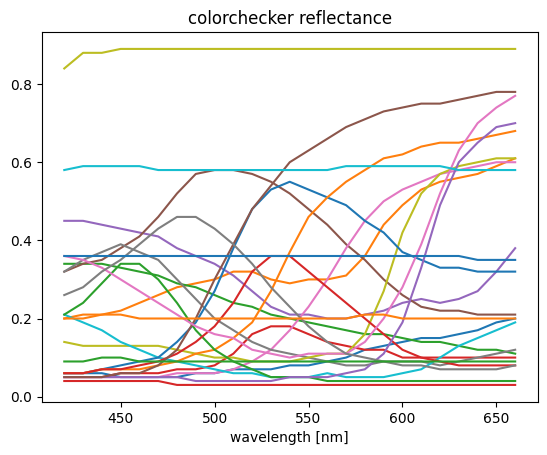

In [28]:
# Replace 'file.csv' with the path to your CSV file
file_path = './dataset/MacbethColorChecker.csv'
# Read the CSV file and store it as a DataFrame
df = pd.read_csv(file_path, header=None, skiprows=2)

# Display the DataFrame

wvls_CC = df.values[1:,0]
wvls_CC = [float(x) for x in wvls_CC] 
ref_CC = df.values[1:,1:-2]

ind_min = 6
ind_max = 61
wvls_CC = wvls_CC[ind_min:ind_max:2] 
ref_CC = ref_CC[ind_min:ind_max:2,:]

# print(wvls_CC, ref_CC)

plt.figure()
plt.plot(wvls_CC[1:-2], ref_CC[1:-2])
plt.title('colorchecker reflectance')
plt.xlabel('wavelength [nm]')

In [29]:
ref_CC[:, 0] # 1번째 idx 는 wvl 에 대한 정보 / 두번째 idx는 patch 1부터 24까지

array([0.07, 0.06, 0.06, 0.06, 0.05, 0.05, 0.05, 0.05, 0.06, 0.06, 0.07,
       0.07, 0.07, 0.08, 0.08, 0.09, 0.1, 0.12, 0.13, 0.14, 0.15, 0.15,
       0.16, 0.17, 0.19, 0.2, 0.22, 0.24], dtype=object)

In [30]:
blue = ref_CC[1:-2,12] # 87, 370
green = ref_CC[1:-2,13] # 218, 370
red = ref_CC[1:-2,14] # 349, 376
white = ref_CC[1:-2,18] # 74, 500

In [31]:
center_pts = np.array([[87, 370],[218, 370],[349, 376],[74, 500]])

In [32]:
color_check_hyp_gt = np.zeros(shape=(cam_H, cam_W, len(wvls)))

In [33]:
color_check_hyp_gt[center_pts[0,1]-patch_size:center_pts[0,1]+patch_size, center_pts[0,0]-patch_size:center_pts[0,0]+patch_size] = blue
color_check_hyp_gt[center_pts[1,1]-patch_size:center_pts[1,1]+patch_size, center_pts[1,0]-patch_size:center_pts[1,0]+patch_size] = green
color_check_hyp_gt[center_pts[2,1]-patch_size:center_pts[2,1]+patch_size, center_pts[2,0]-patch_size:center_pts[2,0]+patch_size] = red
color_check_hyp_gt[center_pts[3,1]-patch_size:center_pts[3,1]+patch_size, center_pts[3,0]-patch_size:center_pts[3,0]+patch_size] = white

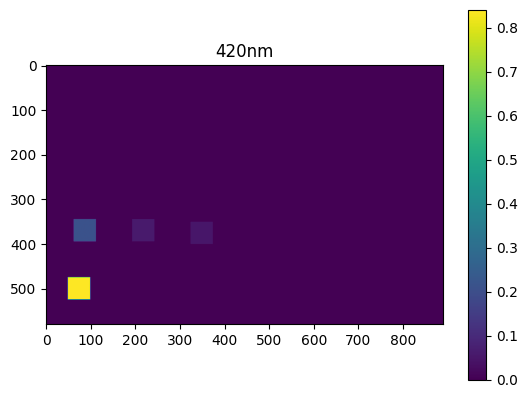

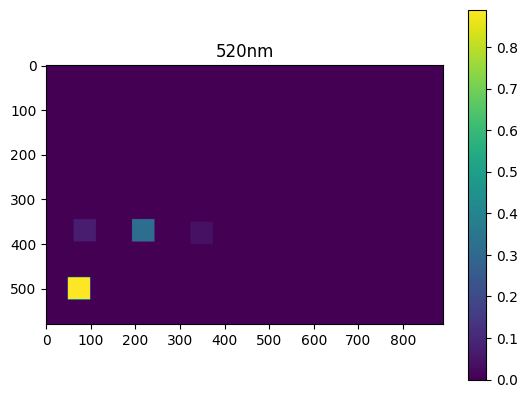

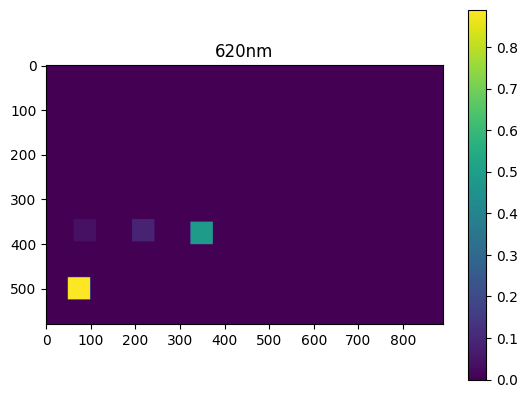

In [49]:
for i in range(0,25,10):
    plt.imshow(color_check_hyp_gt[:,:,i]), plt.colorbar(), plt.title("%snm"%wvls[i])
    plt.show()

In [35]:
np.save('color_check_hyp_gt.npy', color_check_hyp_gt)

### Plotting Graph

#### RGB intensity

In [50]:
N3_arr_simulation = np.load('./N3_arr_simulation.npy')

In [53]:
N3_arr_simulation = N3_arr_simulation.reshape(cam_H, cam_W, n_illum, 3)

In [86]:
# plot reflectance for each patches
# patches : 24개, wvl : 25 개

patches_rgb = np.zeros(shape = (n_illum, n_channel, n_patches))
patches_idx = center_pts

for l in range(n_illum):
    for p in range(n_patches):
        for c in range(n_channel):
            x_idx, y_idx = patches_idx[p][0], patches_idx[p][1]
            rgb_intensity = N3_arr_simulation[y_idx, x_idx, l, c]
            patches_rgb[l, c, p] = rgb_intensity

Text(0.5, 0, 'illumination index')

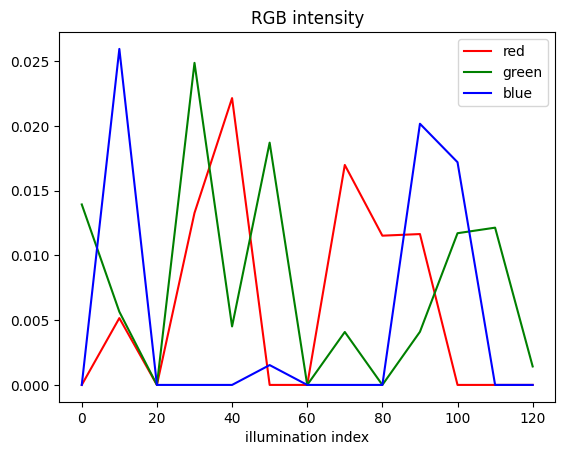

In [95]:
illum = np.arange(0, n_illum, 1)

plt.figure()

plt.plot(illum[::10], patches_rgb[::10,0,0], label = 'red', c = 'red')
plt.plot(illum[::10], patches_rgb[::10,1,0], label = 'green', c = 'green')
plt.plot(illum[::10], patches_rgb[::10,2,0], label = 'blue', c = 'blue')

plt.legend()
plt.title('RGB intensity')
plt.xlabel('illumination index')

#### Hyperspectral reconstruction

In [38]:
X_np_all = np.load('./X_np_all.npy').reshape(cam_H, cam_W, len(wvls))

In [39]:
X_np_all.shape

(580, 890, 25)

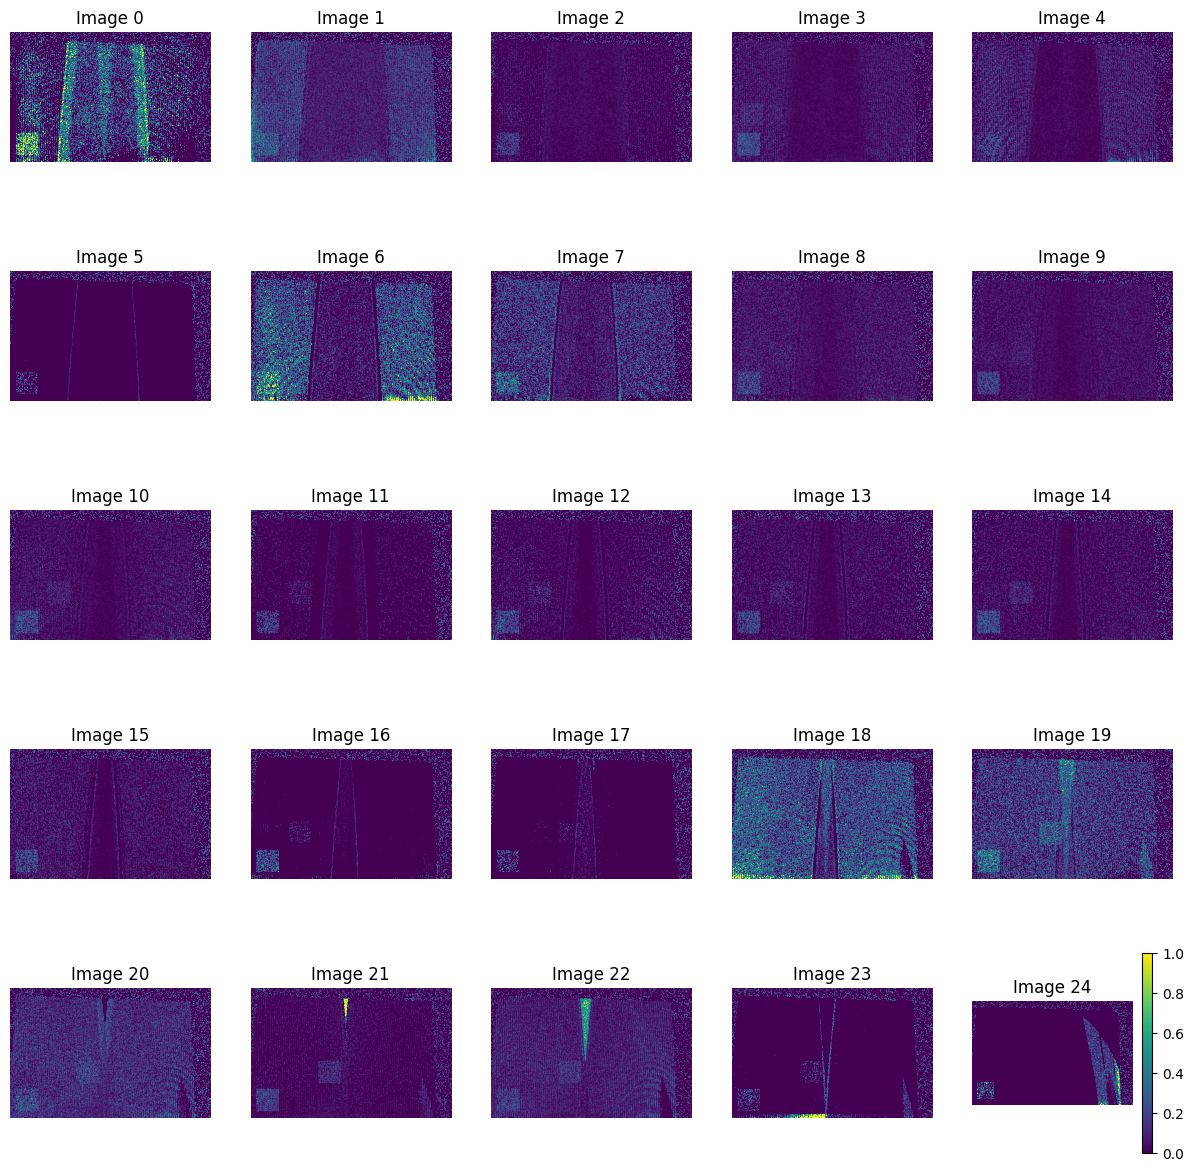

In [40]:
max_images_per_column = 5
num_columns = (len(wvls) + max_images_per_column - 1) // max_images_per_column
plt.figure(figsize=(15, 3*num_columns))

for c in range(num_columns):
    start_index = c * max_images_per_column
    end_index = min(start_index + max_images_per_column, len(wvls))
    num_images = end_index - start_index
    
    for i in range(num_images):
        plt.subplot(num_columns, num_images, i + c * num_images + 1)
        plt.imshow(X_np_all[:, :, i + start_index], vmin=0, vmax=1)
        plt.axis('off')
        plt.title(f"Image {i + start_index}")
        
        if i + start_index == len(wvls) - 1:
            plt.colorbar()

In [42]:
# plot reflectance for each patches
# patches : 24개, wvl : 25 개

patches_reflectance = np.zeros(shape = (len(wvls), n_patches))
patches_idx = center_pts

for p in range(n_patches):
    for w in range(len(wvls)):
        x_idx, y_idx = patches_idx[p][0], patches_idx[p][1]
        mean_ref = X_np_all[y_idx-patch_size:y_idx+patch_size,x_idx-patch_size:x_idx+patch_size, w].mean()
        patches_reflectance[w, p] = mean_ref

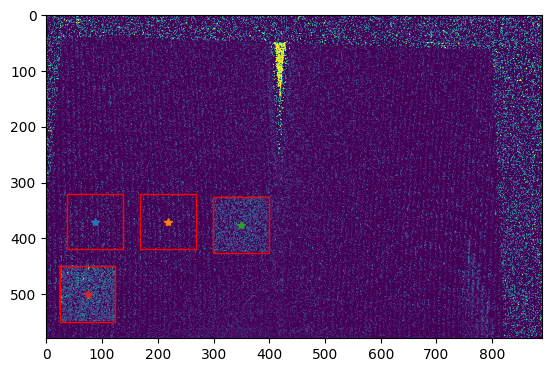

In [72]:
img = X_np_all[...,21]

fig, ax = plt.subplots()
for p in range(n_patches):
    plt.plot(patches_idx[p][0],patches_idx[p][1], "*")
    ax.add_patch(patches.Rectangle([patches_idx[p][0]-p_size,patches_idx[p][1]-p_size], p_size*2, p_size*2, fill = False, edgecolor = 'red'))
    plt.imshow(img, vmin = 0., vmax = 1.)

In [73]:
patches_ref_clip = np.clip(patches_reflectance, 0 ,1)

In [74]:
patches_ref_clip.shape

(25, 4)

Text(0.5, 0, 'wavelength [nm]')

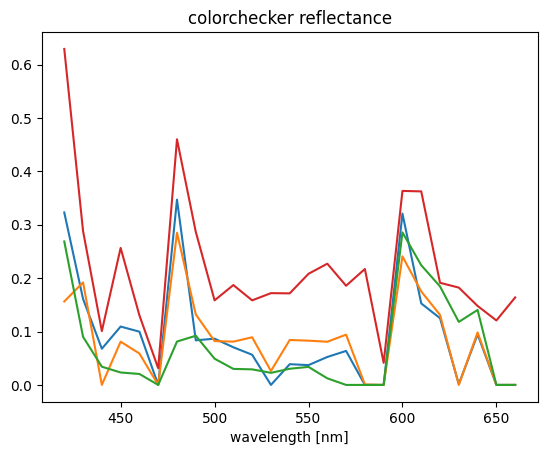

In [75]:
plt.figure()
plt.plot(wvls, patches_ref_clip)
plt.title('colorchecker reflectance')
plt.xlabel('wavelength [nm]')

Text(0.5, 0, 'wavelength [nm]')

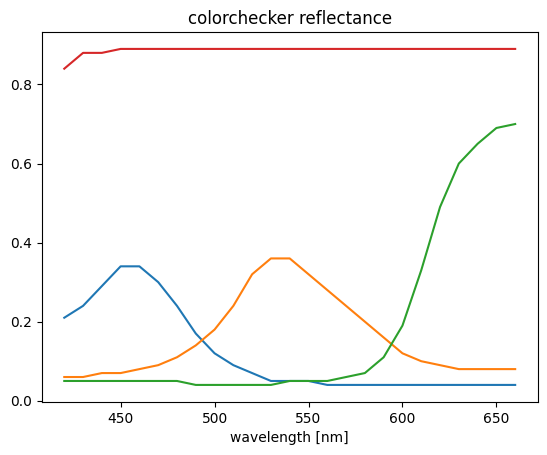

In [47]:
plt.figure()
plt.plot(wvls_CC[1:-2], ref_CC[1:-2,12], label = 'blue')
plt.plot(wvls_CC[1:-2], ref_CC[1:-2,13], label = 'green')
plt.plot(wvls_CC[1:-2], ref_CC[1:-2,14], label = 'red')
plt.plot(wvls_CC[1:-2], ref_CC[1:-2,18], label = 'white')

plt.title('colorchecker reflectance')
plt.xlabel('wavelength [nm]')